# DeepLinc

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 05.01.2023
- **Date of Last Modification:** 09.01.2023

- The DeepLinc source code is available at https://github.com/xryanglab/DeepLinc.
- The corresponding publication is Li, R. & Yang, X. De novo reconstruction of cell interaction landscapes from single-cell spatial transcriptome data with DeepLinc. Genome Biol. 23, 124 (2022).
- The logic to run DeepLinc is encapsulated into the Python script 'deeplinc.py'.
- We train DeepLinc models on the seqfish mouse organogenesis embryo 2 dataset with different adjacency matrices corresponding to 2, 4, 8, 16, and 32 average neighbors. To train a DeepLinc model with 2 average neighbors, open a terminal, navigate to the 'deeplinc' folder, and run ```python deeplinc.py -e ../datasets/srt_data/gold/seqfish_mouse_organogenesis_embryo2_counts.csv -a ../datasets/srt_data/gold/seqfish_mouse_organogenesis_embryo2_adj2.csv -c ../datasets/srt_data/gold/seqfish_mouse_organogenesis_embryo2_coords.csv -r ../datasets/srt_data/gold/seqfish_mouse_organogenesis_embryo2_cell_types.csv -n run1 -i 40```.
- The results of the trained DeepLinc models (latent space features & reconstructed adjacency matrices) are manually stored in ```../datasets/benchmark_data/deeplinc/```. This notebook should be run after training of DeepLinc models is completed.

## 1. Setup

### 1.1 Import Libraries

In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc

### 1.2 Define Parameters

In [2]:
dataset = "squidpy_seqfish_mouse_organogenesis"
cell_type_key = "celltype_mapped_refined"
latent_key = "deeplinc_latent"
n_neighbors = 8 # used for UMAP plot
leiden_resolution = 0.3 # used for Leiden clustering of latent space
random_seed = 0

### 1.3 Run Notebook Setup

In [3]:
sc.set_figure_params(figsize=(6, 6))

In [4]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [5]:
data_folder_path = "../datasets/srt_data/gold/"
figure_folder_path = f"../figures/{dataset}/benchmarking/"
benchmark_data_folder_path = "../datasets/benchmark_data/"

## 2. Data

In [6]:
# Load Data
adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
adata.layers["counts"] = adata.layers["counts"].tocsr()
adata.obs["sample"] = "sample_1"

## 3. DeepLinc Model

In [7]:
# Load latent space features into adata after running 'deeplinc.py' script
run_number = 1
for directory, subdirectory, file_list in os.walk(benchmark_data_folder_path + "deeplinc/embryo2"):
    for file in file_list:
        if "hidden2" in file:
            file_path = os.path.join(directory, file)
            adata.obsm[latent_key + f"_run{run_number}"] = np.load(file_path)
            run_number += 1

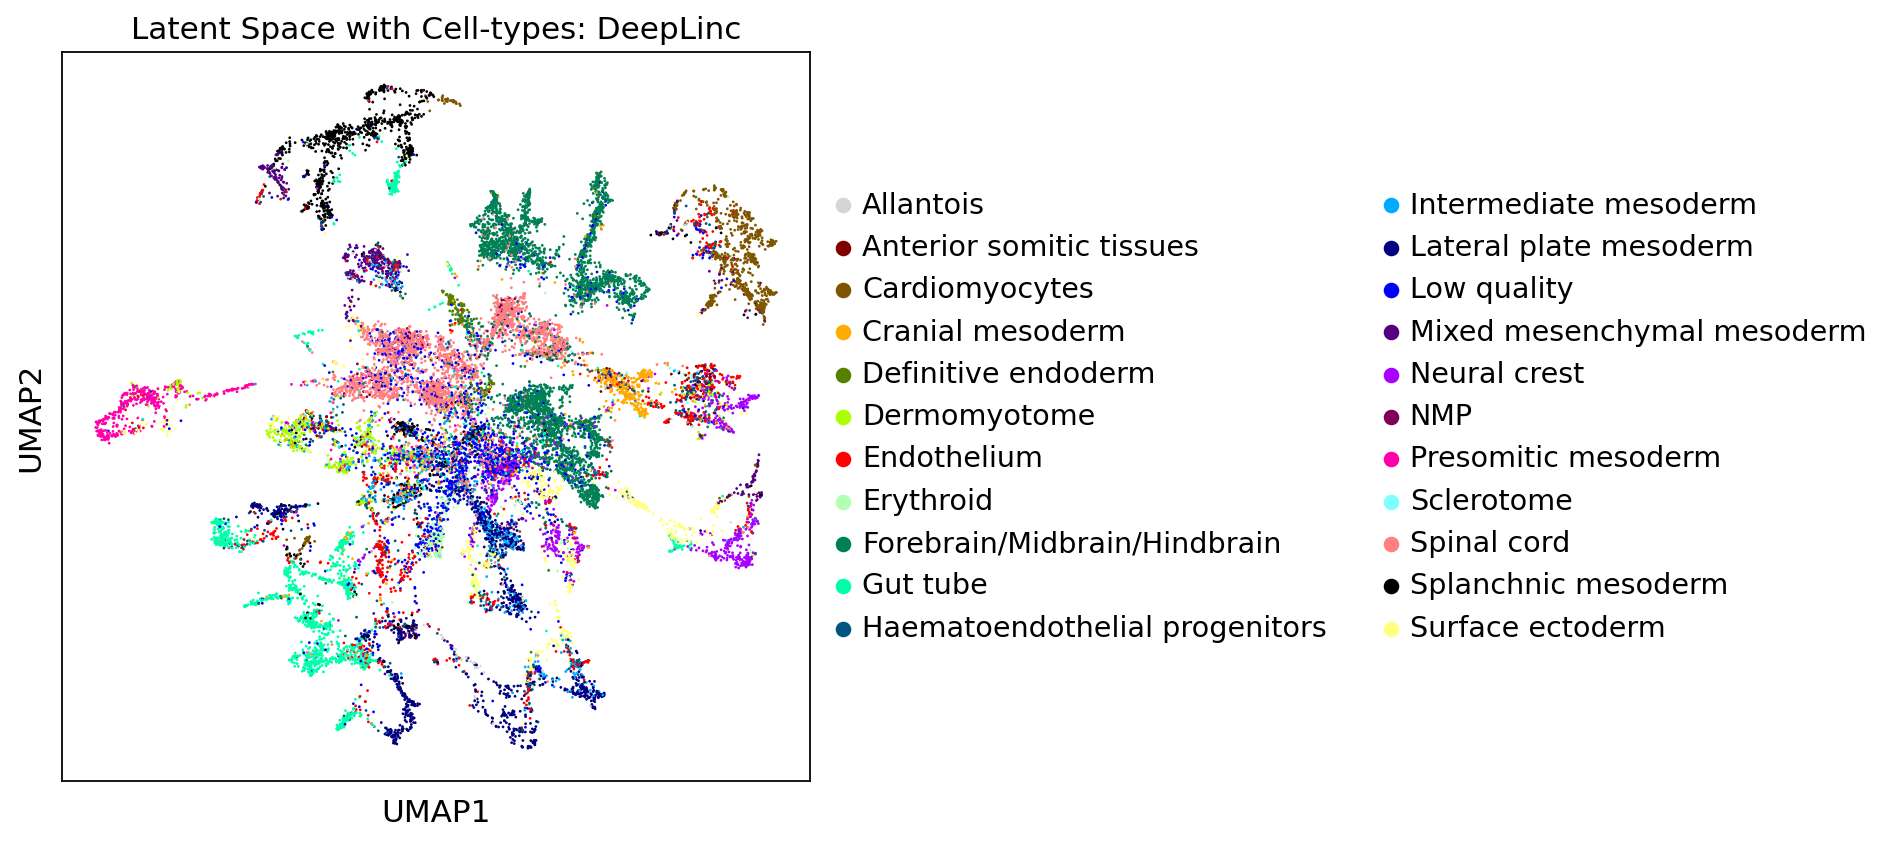

In [8]:
# Use DeepLinc latent space with 8 neighbors for UMAP generation
sc.pp.neighbors(adata, use_rep=latent_key + "_run5", n_neighbors=n_neighbors)
sc.tl.umap(adata, min_dist=0.3)

fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 title="Latent Space with Cell-types: DeepLinc",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_deeplinc_cell_types_{current_timestamp}.png",
            bbox_inches="tight")

In [9]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=adata,
             resolution=leiden_resolution,
             random_state=random_seed,
             key_added=f"latent_deeplinc_leiden_{str(leiden_resolution)}")

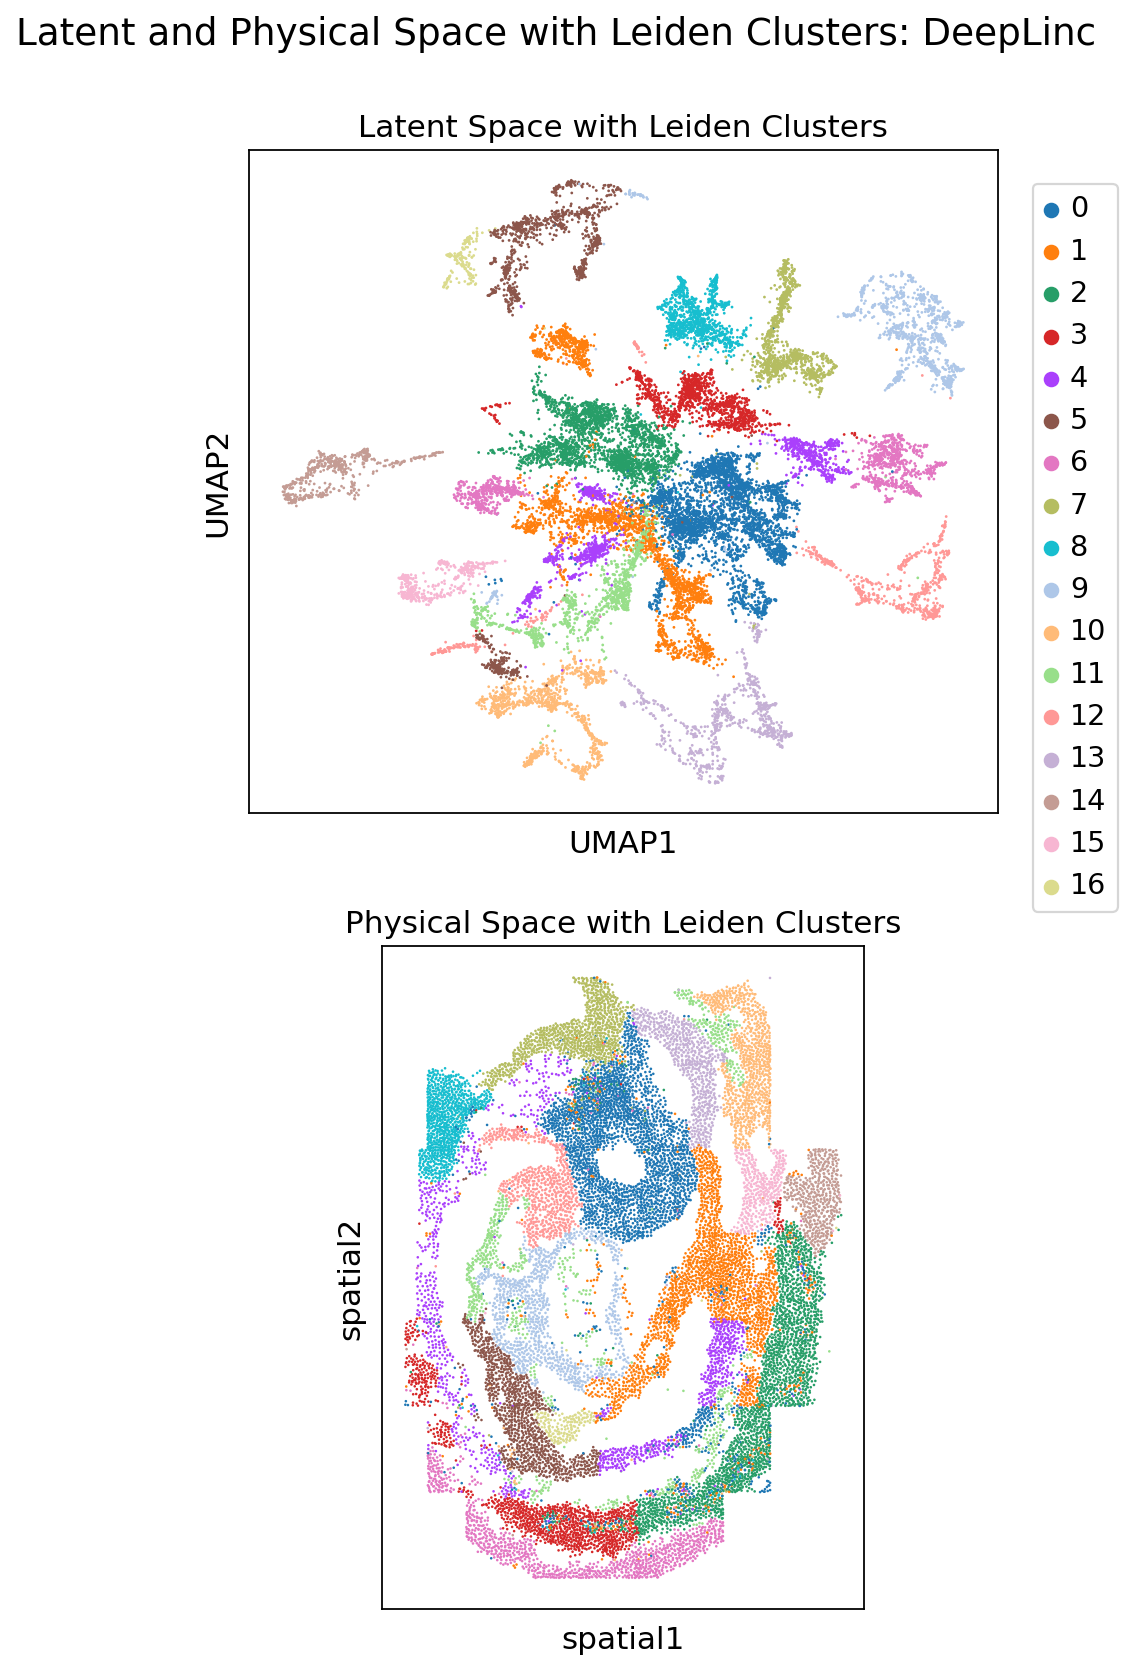

In [10]:
# Create subplot of latent Leiden cluster annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: DeepLinc")
sc.pl.umap(adata=adata,
           color=[f"latent_deeplinc_leiden_{str(leiden_resolution)}"],
           title=f"Latent Space with Leiden Clusters",
           ax=axs[0],
           show=False)
sc.pl.spatial(adata=adata,
              color=[f"latent_deeplinc_leiden_{str(leiden_resolution)}"],
              spot_size=0.03,
              title=f"Physical Space with Leiden Clusters",
              ax=axs[1],
              show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.1, 0.90))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.2)
fig.savefig(f"{figure_folder_path}/latent_physical_comparison_deeplinc_leiden_{current_timestamp}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

In [11]:
# Label all 'gene programs' as active gene programs for subsequent benchmarking
adata.uns["deeplinc_active_gp_names"] = np.array([f"FC_GP_{i}" for i in range(adata.obsm["deeplinc_latent_run1"].shape[1])])

In [12]:
# Store data to disk
adata.write(f"{data_folder_path}/{dataset}_deeplinc.h5ad")